# Import

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy 
from scipy.stats import ttest_ind

In [2]:
#import data and subset meaningful columns
df = pd.read_csv('/Users/zachstone/notebooks/modulargrid/modulargrid_scrape-main/modules.csv')
df = df[['manufacturer_name', 
         'module_name', 
         'module_type',
         'width',
         'depth',
         'current_plus12V','current_minus12V','current_5V',
         'price',
         'num_racks',
         'tags',
         'availability']]

## Prep

In [3]:
#subset eurorack modules
moduledf = df[df.module_type == 'eurorack']
moduledf.drop('module_type', axis =1, inplace=True)
moduledf['tags'] = moduledf['tags'].str.lower()

#Drop accessories
moduledf['accessory_flag'] = moduledf['tags'].str.contains('power|expander|blank panel')
moduledf = moduledf[moduledf.accessory_flag == False].drop('accessory_flag',axis=1)

#Flag unknown brands
moduledf.loc[:,'brand_known'] = moduledf.manufacturer_name.apply(lambda x: x != 'Other/unknown')

#Get branded modules
df_brands = moduledf.loc[(moduledf.brand_known == True) & moduledf.availability.isin(['unknown','avail'])]

#Add log_price and log_racks
df_brands['log_price'] = np.log(df_brands['price'])
df_brands['log_racks'] = np.log(df_brands['num_racks'])


#Make dfs exploded over function
df_brands['functions'] = df_brands.tags.str.split('-')
brands_exploded = df_brands.explode('functions')

#Multi vs. single function flag
df_brands['multifunction'] = df_brands['functions'].apply(lambda x: len(x)>1)

#Known price flag
df_brands['price_known'] = df_brands.price.notnull()


# moduledf['functions'] = moduledf.tags.str.split('-')
# modules_exploded = moduledf.explode('functions')

numeric = ['width', 'price', 'log_price', 'num_racks', 'log_racks']

/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_78404/4161086166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moduledf.drop('module_type', axis =1, inplace=True)
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_78404/4161086166.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moduledf['tags'] = moduledf['tags'].str.lower()
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_78404/4161086166.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [4]:
# brand_dummy = pd.get_dummies(df_brands, columns = ['manufacturer_name']).drop(['depth', 'current_plus12V', 'current_minus12V','current_5V'], axis = 1)

In [5]:
df_brands.columns

Index(['manufacturer_name', 'module_name', 'width', 'depth', 'current_plus12V',
       'current_minus12V', 'current_5V', 'price', 'num_racks', 'tags',
       'availability', 'brand_known', 'log_price', 'log_racks', 'functions',
       'multifunction', 'price_known'],
      dtype='object')

In [6]:
df_brands[numeric].describe()

,width,price,log_price,num_racks,log_racks
count,7066.000000,6337.000000,6337.000000,7066.000000,7066.000000
mean,11.425984,205.569355,5.009676,750.310784,5.076368
std,10.099868,192.082718,0.821428,2282.390905,1.744566
min,1.000000,4.000000,1.386294,1.000000,0.000000
25%,6.000000,90.000000,4.499810,45.000000,3.806662
50%,8.000000,160.000000,5.075174,142.000000,4.955827
75%,14.000000,259.000000,5.556828,536.750000,6.285532
max,104.000000,3999.000000,8.293800,52604.000000,10.870547


# Prep data on each brand

In [7]:
brand_data = pd.DataFrame({'manufacturer_name': df_brands.manufacturer_name.unique()})

#Add column for number of unique functions that brand makes
brand_data = brand_data.merge(
    brands_exploded.groupby('manufacturer_name')['functions'].unique().apply(len)\
        .reset_index(), 
    on = 'manufacturer_name')

#Add column for number of modules produced by each company
brand_data = brand_data.merge(
    df_brands.groupby('manufacturer_name')['module_name'].unique().apply(len)\
        .reset_index(), 
    on = 'manufacturer_name')

#Add column for average popularity of all products by brand
brand_data = brand_data.merge(
    df_brands.groupby('manufacturer_name')['num_racks'].mean()\
        .reset_index(), 
    on = 'manufacturer_name')

#Add column for max popularity of product by brand
brand_data = brand_data.merge(
    df_brands.groupby('manufacturer_name')['num_racks'].max()\
        .reset_index(), 
    on = 'manufacturer_name')


brand_data.columns = ['brand', 'n_functions', 'n_modules', 'product_avg_racks', 'product_max_racks']

#Add number and percent of products which are in top 5% most popular products for each brand
top_products = df_brands.sort_values(by = 'num_racks', ascending = False).iloc[:int(0.05 * len(df_brands))+1,:]

brand_data = brand_data.merge(
    top_products.groupby('manufacturer_name')['module_name'].unique().apply(len)\
        .reset_index().rename(columns={'module_name':'n_top_products'}),
    left_on = 'brand',
    right_on = 'manufacturer_name',
    how='left'
).drop('manufacturer_name',axis=1)

brand_data.n_top_products = brand_data.n_top_products.fillna(0)

brand_data['per_top_products'] = brand_data.n_top_products / brand_data.n_modules

brand_data

,brand,n_functions,n_modules,product_avg_racks,product_max_racks,n_top_products,per_top_products
0,000,10,8,60.875000,107.0,0.0,0.000000
1,1010 Music,23,11,1358.090909,5688.0,2.0,0.181818
2,256klabs,5,6,26.000000,51.0,0.0,0.000000
3,2hp,34,96,1870.608247,10928.0,14.0,0.145833
4,4ms Company,29,44,2101.244444,11519.0,9.0,0.204545
...,...,...,...,...,...,...,...
515,VH.S,6,2,20.000000,21.0,0.0,0.000000
516,Wildsync,8,8,30.500000,60.0,0.0,0.000000
517,x1l3,18,11,107.615385,570.0,0.0,0.000000
518,XOXO Modular,6,5,117.800000,427.0,0.0,0.000000


Another question we could ask:

Say that a module is "highly popular" for a function if it is in the top 5% popularity.

Do popular companies with high total popularity have many popular items accross functions, or is it concentrated on a few functions?

Are highly popular items spread across applications or have similar applications?

For each function, what function pairing(s) have highest popularity?

# EDA
modulesdf contains all eurorack modules, even without brand name, with 'accessories' (blank panels, power strips, expanders) dropped. About 20% of all modules are missing price.

brand_df is the subset for modules with brand names listed. About 10% of prices are missing for branded modules.

Some useful but non-obvious business questions: 
1) What functions are optimal for single-use modules? What are their optimal sizes and pricings?
2) What functions are optimal for multi-use modules? What are their optimal sizes and pricings?
3) What are good choices for combinations of functions for multi-use modules? Are certain groupings more popular at certain sizes? What price points are good for that?
4) What 'gaps' might exist for multi-use modules? E.g. popular functions at that size and price point.

These will have to be broken up. We should look at:
-general correlations

a) popularity of different types

b) size distribution of different types

c) price vs popularity

d) for each type, to what extent does price vs size vs brand vs combos predict popularity

Plan:
1. Single variable
- Distribution for price
- Popularity
- Width

2. Categorical variables
- popularity and function

3. Comparison of variables
- correlation between numerical variables
- popularity and price for single vs multifunction
- size against popularity by function and single vs. multifunction
- brand and popularity
- How many/what functions does each brand make? If there is a difference in number of functions each brand makes?

# Single variable stats

## Price and functionality

Price is somewhat log-normal, but has some irregularities.

Mean price is different for single and multifunction modules with p<0.01. For single function modules, log(price) is much closer to normal. However, for multifunction, it is left-skewed. Other factors may be at play, such as number of functions or types of functions.

(array([   7.,   42.,  232.,  567., 1644., 2210., 1277.,  317.,   36.,
           5.]),
 array([1.38629436, 2.07704489, 2.76779541, 3.45854594, 4.14929646,
        4.84004698, 5.53079751, 6.22154803, 6.91229856, 7.60304908,
        8.29379961]),
 <BarContainer object of 10 artists>)

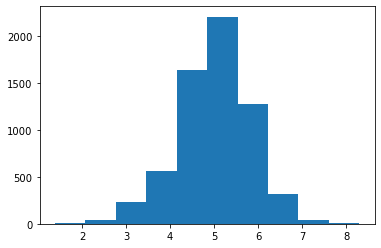

In [8]:
plt.hist(np.log(df_brands.price))

<AxesSubplot:xlabel='price', ylabel='Density'>

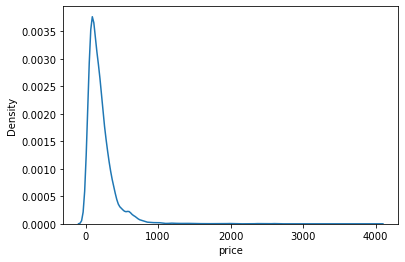

In [9]:
sns.kdeplot(df_brands.price)

We check log_price

<AxesSubplot:xlabel='price', ylabel='Density'>

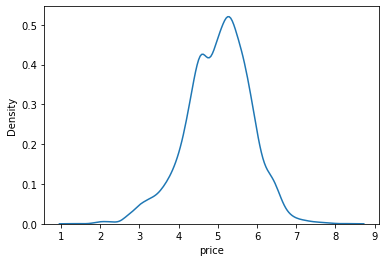

In [10]:
sns.kdeplot(np.log(df_brands.price))

In [11]:
scipy.stats.describe(df_brands.log_price.dropna().values)

DescribeResult(nobs=6337, minmax=(1.3862943611198906, 8.293799608846818), mean=5.009675841278094, variance=0.6747437410949441, skewness=-0.3363614073023695, kurtosis=0.4946002837322361)

In [12]:
mean_log_price, std_log_price = np.log(df_brands[df_brands.price.notnull()].price).agg([np.mean,np.std]).values

<AxesSubplot:xlabel='log_racks', ylabel='Proportion'>

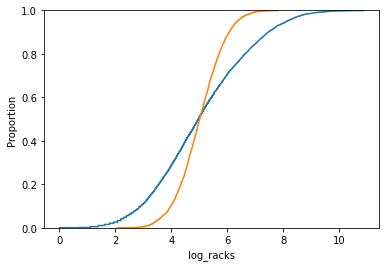

In [13]:
fig, ax = plt.subplots()

sns.ecdfplot(x='log_racks',data = df_brands, ax =ax)
sns.ecdfplot(np.random.normal(loc = mean_log_price, scale = std_log_price, size = 5000), ax=ax)

log(price) better behaved, but still not perfectly normal. Like with size, better distributions may hold among subclasses. We first check single vs. multifunction.

Text(0.5, 1.0, 'Multifunction vs. Price')

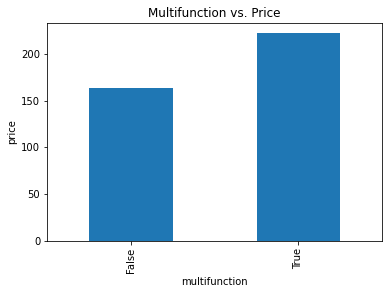

In [14]:
ax = df_brands.groupby('multifunction')['price'].mean().plot(kind = 'bar') #multifunction modules are significantly more popular
ax.set_ylabel('price')
ax.set_title('Multifunction vs. Price')

In [15]:
multifunction_price = df_brands[df_brands.multifunction].loc[df_brands.price.notnull()].loc[:,'price'].values
singlefunction_price = df_brands[~df_brands.multifunction].loc[df_brands.price.notnull()].loc[:,'price'].values

In [16]:
ttest_ind(multifunction_price, singlefunction_price, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=12.468926664514205, pvalue=2.1038616105596615e-35)

We can see that single vs. multifunction come from different price distributions with different means.

In [17]:
single_price_mean, single_price_std = (np.mean(np.log(singlefunction_price)), np.std(np.log(singlefunction_price)))

<AxesSubplot:ylabel='Proportion'>

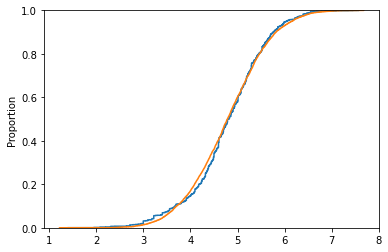

In [18]:
fig, ax = plt.subplots()

sns.ecdfplot(np.log(singlefunction_price), ax =ax)
sns.ecdfplot(np.random.normal(loc = single_price_mean, scale = single_price_std, size = 5000), ax=ax)

Log(price) for single-function is much closer to normal. We now check multifunction.

In [19]:
multi_price_mean, multi_price_std = (np.mean(np.log(multifunction_price)), np.std(np.log(multifunction_price)))

<AxesSubplot:ylabel='Proportion'>

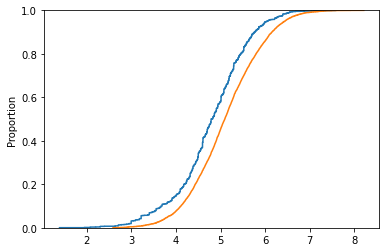

In [20]:
fig, ax = plt.subplots()

sns.ecdfplot(np.log(singlefunction_price), ax =ax)
sns.ecdfplot(np.random.normal(loc = multi_price_mean, scale = multi_price_std, size = 5000), ax=ax)

In [21]:
scipy.stats.describe(np.log(multifunction_price))

DescribeResult(nobs=4531, minmax=(1.9459101490553132, 8.293799608846818), mean=5.099760316272254, variance=0.6457421205565778, skewness=-0.33471108189064325, kurtosis=0.512077292382076)

log_price for multifunction is skewed left

## Popularity
Based on num_racks is almost exactly log-normal. log(num_racks) can be treated like a normally distributed quantity.

<AxesSubplot:ylabel='Frequency'>

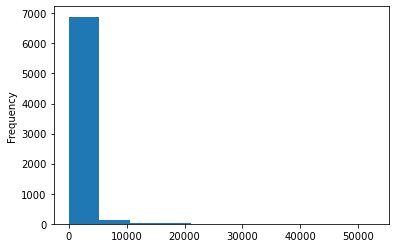

In [22]:
df_brands.num_racks.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

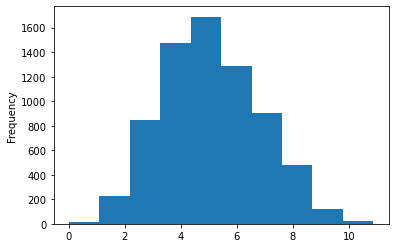

In [23]:
np.log(df_brands.num_racks).plot(kind='hist')

In [24]:
mean_log_pop, std_log_pop = np.log(df_brands.num_racks).agg([np.mean,np.std]).values

<AxesSubplot:xlabel='log_racks', ylabel='Proportion'>

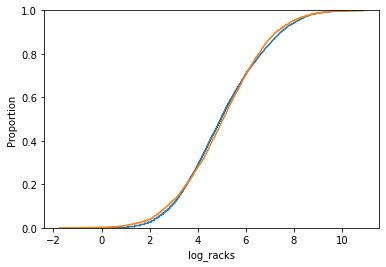

In [25]:
fig, ax = plt.subplots()

sns.ecdfplot(x='log_racks',data = df_brands, ax =ax)
sns.ecdfplot(np.random.normal(loc = mean_log_pop, scale = std_log_pop, size = 5000), ax=ax)

log(num_racks) better behaved

## Size (width in hp)

More idiosyncratic distribution. While there are certain highly frequent sizes, the distribution is not (log-)normal, and the frequent sizes aren't necessarily more popular. A typical distribution and correlation with popularity may only hold within certain subgroups, if at all.

However, the distributions of multi and single function modules do have significantly different means, which should be kept in mind when looking at comparisons against width.

## Function
There are about 3k more multifunction modules than single function

In [26]:
df_brands.groupby('multifunction').size()

multifunction
False    2101
True     4965
dtype: int64

<AxesSubplot:ylabel='Frequency'>

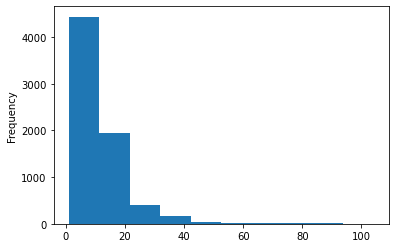

In [27]:
df_brands.width.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

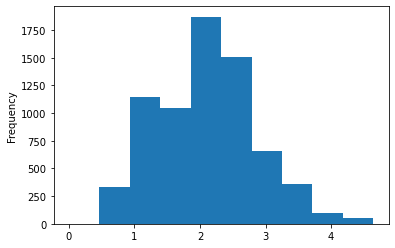

In [28]:
np.log(df_brands.width).plot(kind='hist')

<AxesSubplot:xlabel='width', ylabel='Density'>

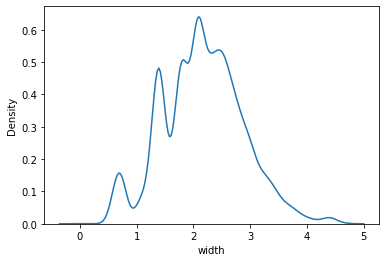

In [29]:
sns.kdeplot(np.log(df_brands.width)) 

Sizes have more unusual distribution. First check against single vs. multifunction.

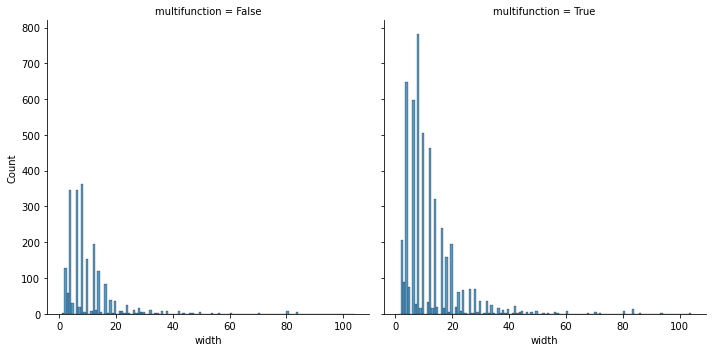

In [30]:
sns.displot(x= 'width', data = df_brands, col = 'multifunction', kind = 'hist', log_scale = False)

Some irregularities are teased apart into the two groups. We look more closely at their distribution, and check that their means are significantly different.

In [31]:
def IQR(dist):
    return np.percentile(dist, 75) - np.percentile(dist, 25)

def cutoff(dist):
    return np.percentile(dist,75) + 1.5 * IQR(dist)

In [32]:
df_brands.groupby('multifunction')[['width']].agg([np.mean,np.std,IQR])

width                
                    mean        std  IQR
multifunction                           
False          10.109948   9.393301  8.0
True           11.982880  10.334958  8.0

In [33]:
df_brands[df_brands.price.notnull()].groupby('multifunction')[['width']].agg([np.mean,np.std,IQR])

width                
                    mean        std  IQR
multifunction                           
False          10.033776   9.288928  8.0
True           11.834253  10.168541  8.0

Single and multi-use modules have similar width distributions, with multifunction being larger by about 2hp.

We can check if the difference is signficant with a 2-sample ttest with p=0.05.

In [34]:
from scipy.stats import ttest_ind

In [35]:
multifunction_w = df_brands[df_brands.multifunction].loc[:,'width'].values
singlefunction_w = df_brands[~df_brands.multifunction].loc[:,'width'].values

In [36]:
ttest_ind(multifunction_w, singlefunction_w, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=7.431973571153125, pvalue=6.412489290295425e-14)

The result is significant, so we can assume they come from different distributions.

We also note that visual inspection shows some very frequent sizes. It may be that these sizes are 'standards' which skew the distribution. In this way, the frequent sizes may be more like ordered categoricals/classes.

In [37]:
# df_brands.width.value_counts(sort=True, normalize=True).iloc[::-1].plot(kind='barh', figsize = (5,12))

In [38]:
df_brands.width.value_counts(sort=True, normalize=True).head(20)

8.0     0.161902
4.0     0.140815
6.0     0.133456
10.0    0.092980
12.0    0.092980
14.0    0.062412
2.0     0.047269
16.0    0.045429
20.0    0.032692
18.0    0.028022
3.0     0.020804
5.0     0.014718
24.0    0.013020
28.0    0.011746
26.0    0.011180
22.0    0.009765
7.0     0.006652
32.0    0.006652
30.0    0.005944
11.0    0.005661
Name: width, dtype: float64

We can see that after 2hp, the proportion of modules of each size quickly drops below 5% of all modules. Let's check if there are any popularity standouts by width.

In [39]:
df_brands.width.unique().size

62

We look at the popularity of each width for single and multifunction modules

<AxesSubplot:ylabel='width'>

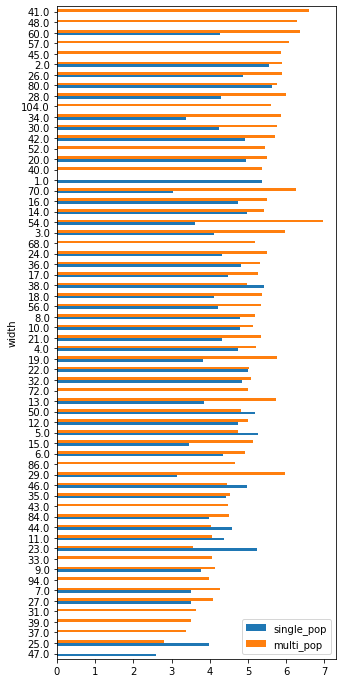

In [40]:
width_pop = df_brands.groupby(['multifunction', 'width'])[['log_racks']]\
                .mean().unstack().T.reset_index('width').reset_index(drop=True)
width_pop.columns = ['width', 'single_pop', 'multi_pop']
width_pop = width_pop.merge(df_brands.groupby('width')[['log_racks']].mean().reset_index(), on = 'width', how='outer')
width_pop.sort_values(by='log_racks').drop('log_racks', axis=1).plot(x = 'width', kind='barh', figsize = (5,12))

<AxesSubplot:ylabel='width'>

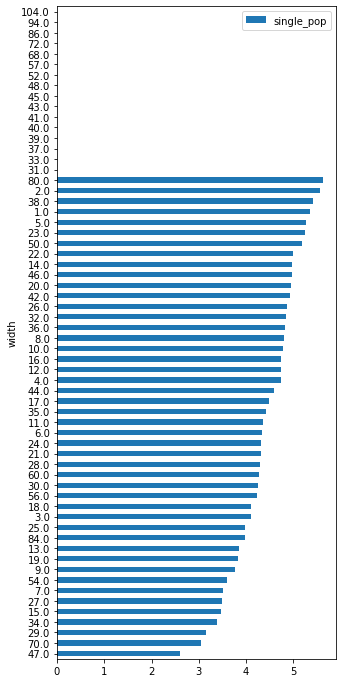

In [41]:
width_pop[['width','single_pop']].sort_values('single_pop').plot(x='width', kind = 'barh', figsize = (5,12))

<AxesSubplot:ylabel='width'>

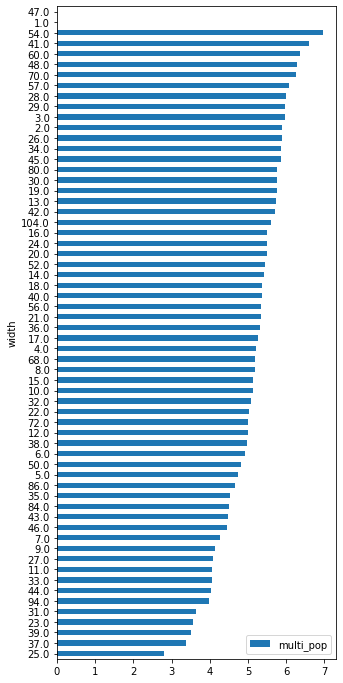

In [42]:
width_pop[['width','multi_pop']].sort_values('multi_pop').plot(x='width', kind = 'barh', figsize = (5,12))

Neither group particularly had the most frequent sizes among the most popular. It is likely popularity vs size only shows up within certain subgroups, if it is a predictor at all.

# Comparison of variables

## Popularity vs. single/multi-function

Multifunction modules are significantly more popular. We also plot basic stats like popularity of each function.

Multifunction modules will be counted in every category they are contained in when looking at stats by function. 

We will also look at multi v. single function and popularity

Text(0.5, 1.0, 'Multifunction vs. Popularity')

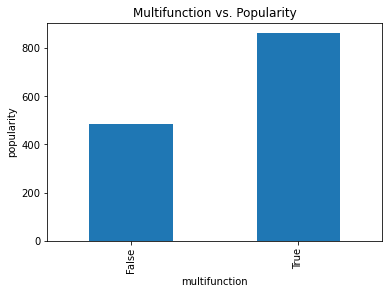

In [43]:
ax = df_brands.groupby('multifunction')['num_racks'].mean().plot(kind = 'bar') #multifunction modules are significantly more popular
ax.set_ylabel('popularity')
ax.set_title('Multifunction vs. Popularity')

We can clearly see that multifunction modules are more popular than single function. To verify:

In [44]:
multifunction_p = df_brands[df_brands.multifunction].loc[:,'num_racks'].values
singlefunction_p = df_brands[~df_brands.multifunction].loc[:,'num_racks'].values

In [45]:
ttest_ind(multifunction_p, singlefunction_p, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=8.063546919636027, pvalue=4.3445084120283227e-16)

In [46]:
# brands_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

<AxesSubplot:ylabel='functions'>

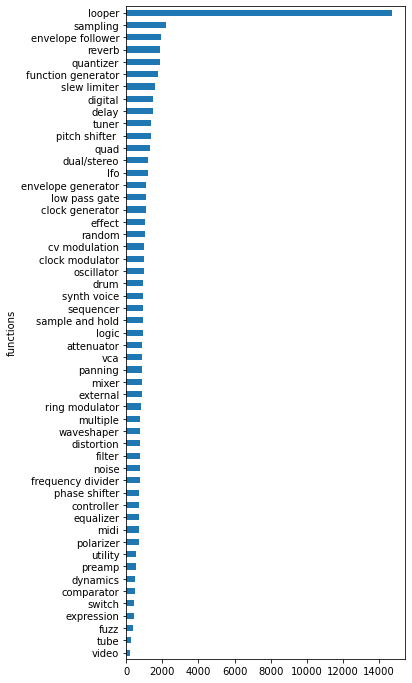

In [47]:
#All functions by popularity
brands_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

In [48]:
brands_exploded.groupby('functions')['num_racks'].mean().sort_values(ascending=False).index

Index(['looper', 'sampling', 'envelope follower', 'reverb', 'quantizer',
       'function generator', 'slew limiter', 'digital', 'delay', 'tuner',
       'pitch shifter ', 'quad', 'dual/stereo', 'lfo', 'envelope generator',
       'low pass gate', 'clock generator', 'effect', 'random', 'cv modulation',
       'clock modulator', 'oscillator', 'drum', 'synth voice', 'sequencer',
       'sample and hold', 'logic', 'attenuator', 'vca', 'panning', 'mixer',
       'external', 'ring modulator', 'multiple', 'waveshaper', 'distortion',
       'filter', 'noise', 'frequency divider', 'phase shifter', 'controller',
       'equalizer', 'midi', 'polarizer', 'utility', 'preamp', 'dynamics',
       'comparator', 'switch', 'expression', 'fuzz', 'tube', 'video'],
      dtype='object', name='functions')

<AxesSubplot:ylabel='functions'>

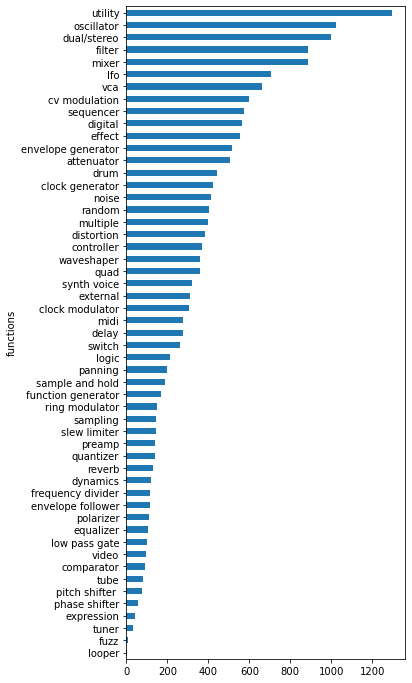

In [49]:
brands_exploded.groupby('functions')['module_name'].unique().apply(len).sort_values().plot(kind = 'barh', figsize = (5,12))

Quantizers, reverbs, samplers, function generators, and loopers all have high popularity but rank low in production. These are areas for possible growth.

In [50]:
# modules_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

In [51]:
brands_exploded.functions.unique().size

53

## Price and popularity

Price and popularity are almost completely decorrelated for both single and multifunction modules, with less than 25% (positive) correlation on both lin-lin and log-log scales. 

Since popularity and price are from distinct distributions for single and multi-function modules, we look at each independently.

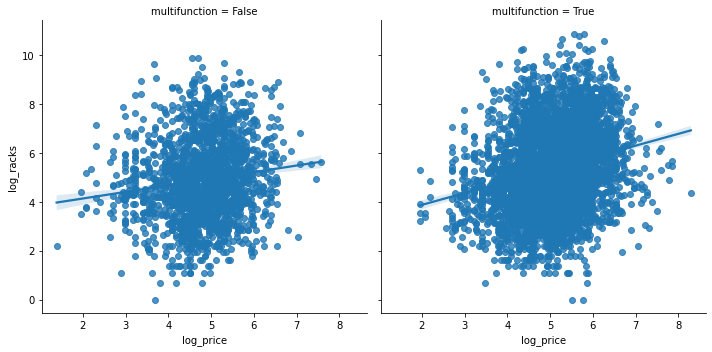

In [52]:
sns.lmplot(x = 'log_price', y = 'log_racks', data = df_brands[df_brands.price_known], col = 'multifunction')

It looks like there is a very weak positive correlation. We check numerically.

In [53]:
#Single function
df_brands[df_brands.price_known & (~df_brands.multifunction)][numeric].drop('width', axis=1).corr()

,price,log_price,num_racks,log_racks
price,1.000000,0.823255,0.038671,0.116730
log_price,0.823255,1.000000,0.061312,0.133353
num_racks,0.038671,0.061312,1.000000,0.637616
log_racks,0.116730,0.133353,0.637616,1.000000


In [54]:
#Multifunction
df_brands[df_brands.price_known & (df_brands.multifunction)][numeric].drop('width', axis=1).corr()

,price,log_price,num_racks,log_racks
price,1.000000,0.809995,0.059688,0.153549
log_price,0.809995,1.000000,0.095564,0.225221
num_racks,0.059688,0.095564,1.000000,0.563899
log_racks,0.153549,0.225221,0.563899,1.000000


Surprisingly, increased price does not seem to lead to a decrease in popularity. The correlation does not reach 25% even in the log-transformed data, so we can see that these are roughly decorrelated.

## Size vs. popularity

Size has an irregular distribution, even when separating single and multi-function modules. We may have to look within-function(s) to see patterns, if they exist.

On the whole, there are not significant correlations between size and popularity within single and multifunction groups.

First check size vs. popularity in single and multi function modules.

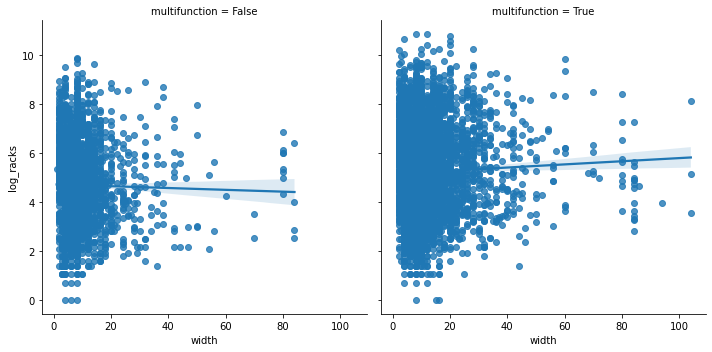

In [55]:
sns.lmplot(x = 'width', y = 'log_racks', data = df_brands, col = 'multifunction')

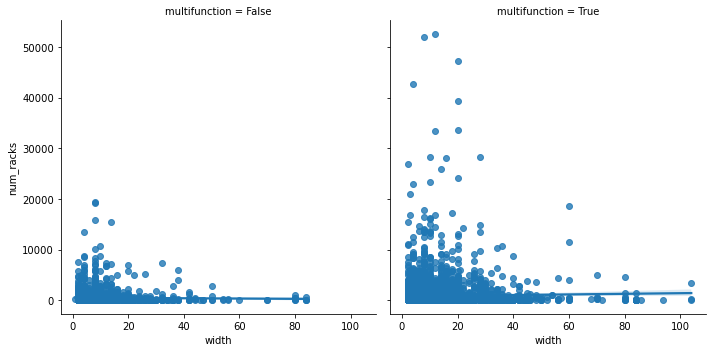

In [56]:
sns.lmplot(x = 'width', y = 'num_racks', data = df_brands, col = 'multifunction')

In [57]:
df_brands[~df_brands.multifunction][numeric].corr()

,width,price,log_price,num_racks,log_racks
width,1.000000,0.582195,0.493926,-0.020332,-0.020698
price,0.582195,1.000000,0.823255,0.038671,0.116730
log_price,0.493926,0.823255,1.000000,0.061312,0.133353
num_racks,-0.020332,0.038671,0.061312,1.000000,0.621931
log_racks,-0.020698,0.116730,0.133353,0.621931,1.000000


No significant correlations. We will have to look at size within smaller groups.

## Popularity of brands

In [58]:
#All functions by popularity
df_brands.groupby('manufacturer_name')['num_racks'].mean().sort_values(ascending=False).head(50)

manufacturer_name
Mutable instruments         20765.400000
DivKid                      14615.500000
Make Noise                   9107.326923
Intellijel                   8397.305085
Strymon                      7678.333333
Moog Music Inc.              6961.000000
Mannequins                   5105.111111
Expert Sleepers              4727.285714
Squarp Instruments           4641.666667
ALM Busy Circuits            4591.107143
Xaoc Devices                 3559.148148
Mordax                       3534.250000
Acid Rain Technology         3212.000000
Rossum Electro-Music         2998.750000
Joranalogue Audio Design     2945.625000
Five12                       2828.000000
Doepfer                      2673.248756
Verbos Electronics           2641.111111
ThreeTom Modular             2641.000000
Instruō                      2494.800000
Winter Modular               2388.333333
Epoch Modular                2305.000000
Rabid Elephant               2263.000000
Empress Effects              2206.00000

## Size, popularity, and function
XXX

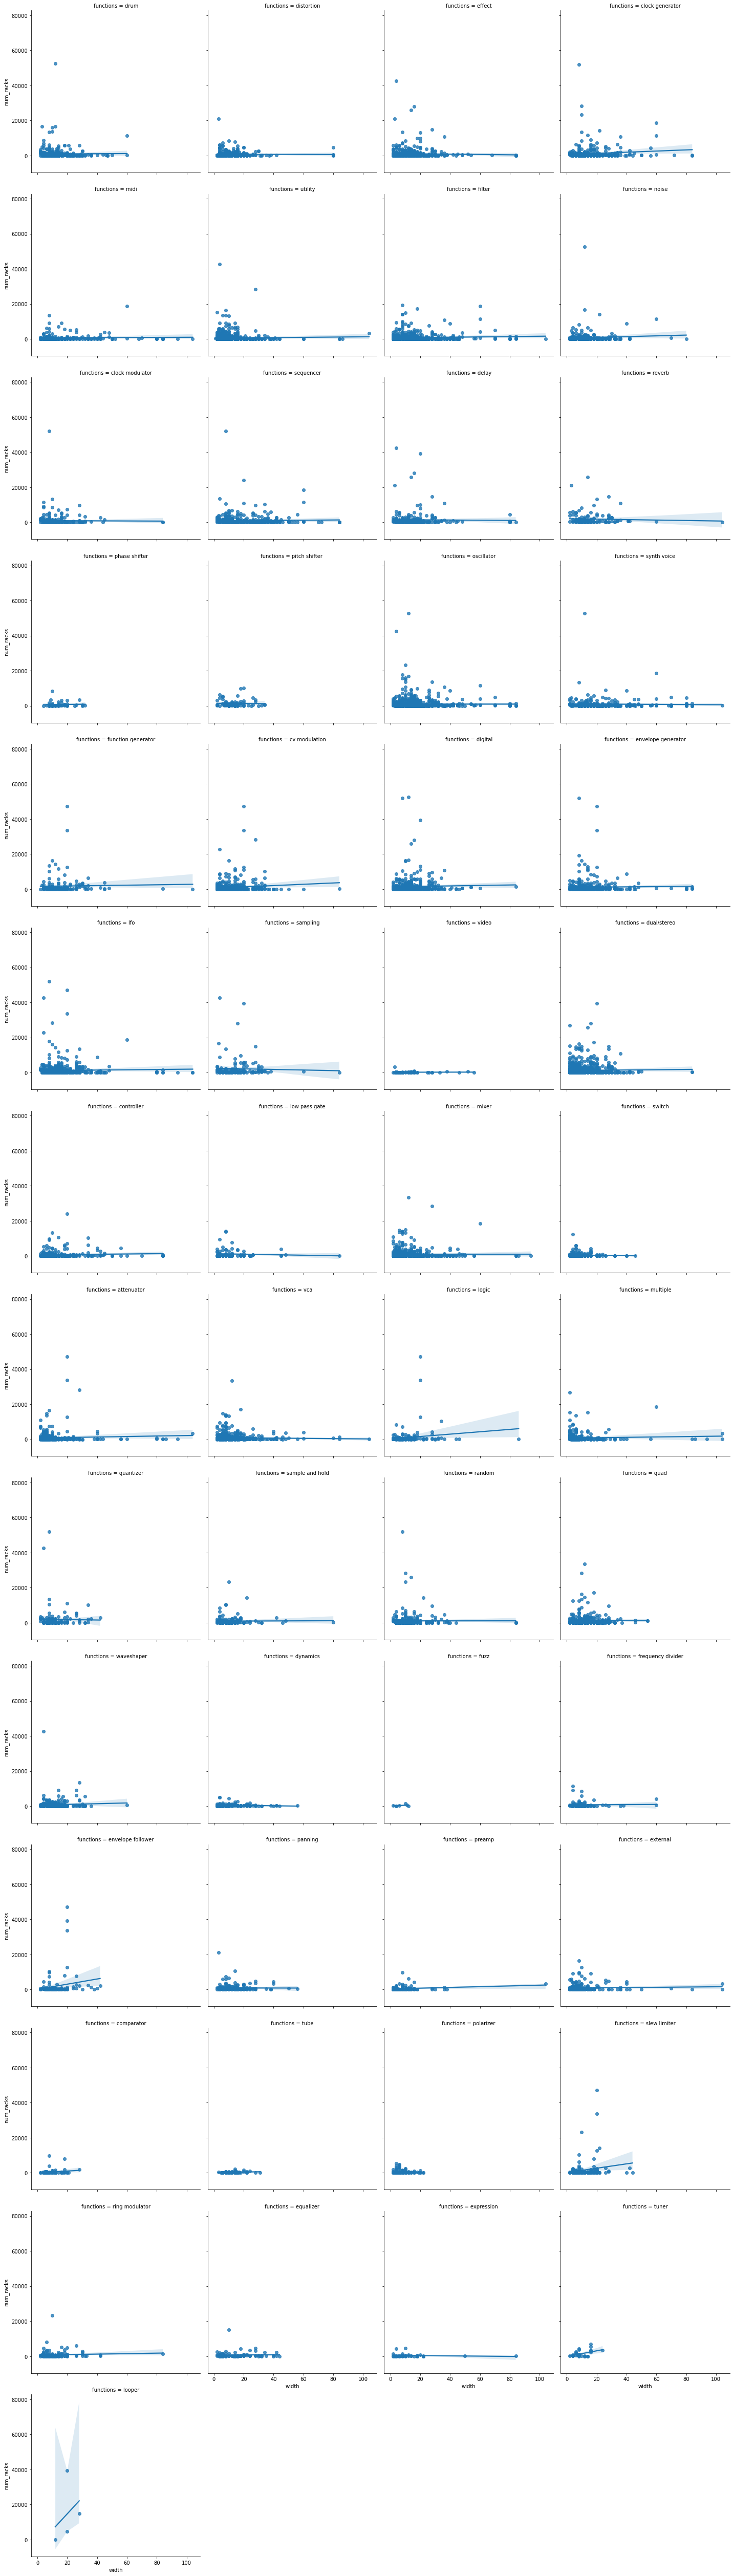

In [59]:
sns.lmplot(x = 'width', y = 'num_racks', data = brands_exploded, col = 'functions', col_wrap = 4)

As expected, the relationship between size and popularity is nonlinear, with popularity leaning towards mid-small sized modules.
To begin analysis of size, we look for size outliers in each category.

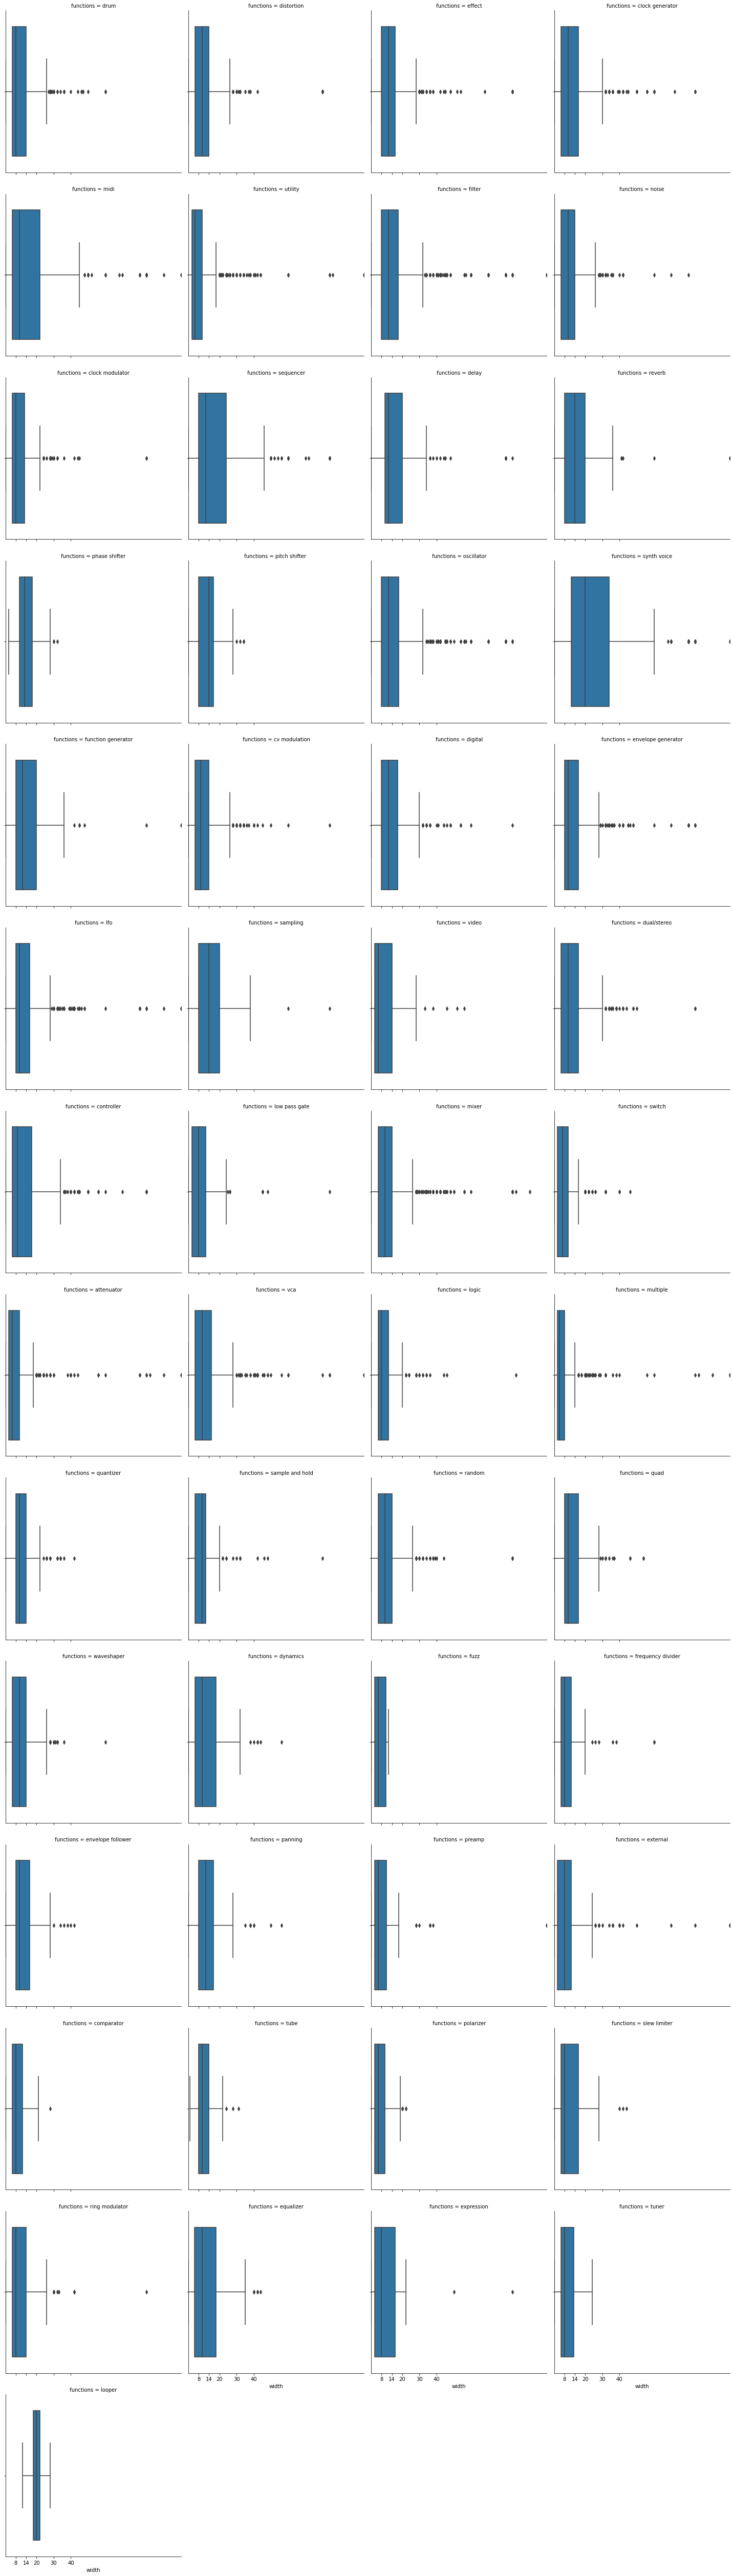

In [60]:
g = sns.catplot(x = 'width', col = 'functions', col_wrap = 4, data = brands_exploded, kind = 'box')
g.set(xlim = (2,np.max(brands_exploded.width)), xticks = [8, 14, 20, 30, 40])

The distribution of outliers over 1.5IQR above Q3 varies greatly between functions, suggesting that they may be different in each group. We should examine the outlier for each kind. This may be due to many factors, such as the outliers for certain functions being due to commonly being on multifunction modules, which may be larger.

In [61]:
function_widths = [*brands_exploded.groupby('functions')['width']]

In [62]:
#Inspecting outliers for each group may be too complicated
# print(function_widths[0][0])
# print(cutoff(function_widths[0][1]))
# np.array(function_widths[0][1:]).reshape(-1,)[(function_widths[0][1] > cutoff(function_widths[0][1:])).values]

# Questions
EDA background:
- popularity is log-normal
- price is loosely log-normal, with large tails and left skew. single function price is much closer to log-normal. less so for multi-function, which has a left skew.
- size is much more idiosyncratic, with multifunction with a significantly larger width by about 1.8 on average.


-multifunction are significantly more popular

-price and popularity are decorrelated

-size has no overall patterns with popularity, probably need more restricted product groups.

So, price is not a great predictor of popularity. We know that multifunctions modules are larger and more popular on the whole, but we will want to get a more in depth analysis by function. We want to look at relations between popularity, size, single vs. multi by function. 

- For each function, are multi-function modules containing that function more or less popular than their single-function counterparts?
-  Are there patterns among the popularity of brands based on the types or breadth of functions they produce?
- For popular functions, are there many popular modules, are a few very popular modules? Are there functions which have more room before they're 'saturated'?
- Do popular brands have many popular products accross functions, or do they tend to have more successful products within a category?


For multifunction:
- Popularity by number of functions
- Function pairings which result in highest popularity.

## Are multi-function modules containing that function more or less popular than their single-function counterparts?

Results:

There are no types of functions where single-function modules have a significant advantage.

However, for brand name modules, there are some categories where they can rank similar to multifunction categories such as areas where they are already successful (video, switch, ...) but even some where multi has only an insigificant advantage (clock modulators, reverb, midi, and sampling)

ZZZ Design idea, show heatgrid of significance to show success of multifunction in each area.

In [63]:
functions = brands_exploded.functions.unique()

In [64]:
singledf = df_brands[~df_brands.multifunction]
multidf = df_brands[df_brands.multifunction]

In [65]:
#Check code for single function
# test_f = np.random.choice(singledf.tags)

# singledf_f = singledf[singledf.tags == test_f]
# multidf_f = multidf[multidf.tags.str.contains(test_f)]

# print(f'single function - multifunction for {test_f}:', np.mean(singledf_f.log_racks) - np.mean(multidf_f.log_racks))
# print('Probabilility of H0:',
#     ttest_ind(singledf_f.log_racks, multidf_f.log_racks, 
#               equal_var = False, random_state = 53, alternative = 'less').pvalue
#      )

In [66]:
def more_pop(n):
    if n<0:
        return 'multi'
    elif n>0:
        return 'single'
    elif n==0:
        return 'equal'
    else:
        return 'na'
    
def is_significant(p):
    if p<0.05:
        return True
    else:
        return False

In [67]:
func_testresults = pd.DataFrame(columns = ['function', 'avg_log_racks_single', 'avg_log_racks_multi', 'dif', 'pval'])

for function in functions:
    singledf_f = singledf[singledf.tags == function]
    multidf_f = multidf[multidf.tags.str.contains(function)]
    
    if any(singledf_f) & any(multidf_f):
        func_results = pd.DataFrame({'function': [function], 
                                        'avg_log_racks_single': [np.mean(singledf_f.log_racks)], 
                                        'avg_log_racks_multi': [np.mean(multidf_f.log_racks)],
                                        'dif': [np.mean(singledf_f.log_racks) - np.mean(multidf_f.log_racks)],
                                        'pval':  [ttest_ind(singledf_f.log_racks, multidf_f.log_racks, 
                                                equal_var = False, random_state = 53, alternative = 'less').pvalue]})
    elif any(multidf_f):
        func_results = pd.DataFrame({'function': [function], 
                                        'avg_log_racks_single': [np.nan], 
                                        'avg_log_racks_multi': [np.mean(multidf_f.log_racks)],
                                        'dif': [np.nan],
                                        'pval':  [np.nan]})
    else:
        func_results = pd.DataFrame({'function': [function], 
                                        'avg_log_racks_single': [np.mean(singledf_f.log_racks)], 
                                        'avg_log_racks_multi': [np.nan],
                                        'dif': [np.nan],
                                        'pval':  [np.nan]})
    
    func_testresults = pd.concat([func_testresults, func_results])

func_testresults.reset_index(drop=True, inplace=True)
func_testresults['more_pop'] = func_testresults.dif.apply(more_pop)
func_testresults['significant'] = func_testresults.pval.apply(is_significant)

In [68]:
#Find places where single function has an advantage

func_testresults[func_testresults.more_pop == 'single']

,function,avg_log_racks_single,avg_log_racks_multi,dif,pval,more_pop,significant
22,video,4.859073,4.301304,0.557769,0.99377,single,False
27,switch,4.670271,4.643655,0.026616,0.537186,single,False
31,multiple,5.279726,4.777161,0.502565,0.995853,single,False
37,dynamics,5.224896,5.205584,0.019312,0.511804,single,False
39,frequency divider,6.328889,5.193496,1.135393,0.784241,single,False
44,comparator,6.884983,4.742513,2.14247,0.959063,single,False


There are no functions for which being single function is a popularity advantage.

In [69]:
#Find places where single may be able to compete

func_testresults[(func_testresults.more_pop == 'multi') & ~func_testresults.significant].sort_values(by = 'pval', ascending=False)

,function,avg_log_racks_single,avg_log_racks_multi,dif,pval,more_pop,significant
8,clock modulator,5.297054,5.336316,-0.039262,0.461775,multi,False
11,reverb,6.2388,6.358796,-0.119996,0.439944,multi,False
4,midi,4.827294,4.911555,-0.08426,0.382067,multi,False
21,sampling,6.122036,6.32426,-0.202224,0.302923,multi,False
13,pitch shifter,5.370108,6.121272,-0.751165,0.241205,multi,False
50,expression,3.646169,4.784164,-1.137996,0.238764,multi,False
41,panning,5.138284,5.443667,-0.305383,0.182,multi,False
51,tuner,5.541909,6.199879,-0.65797,0.171629,multi,False
30,logic,4.766134,5.064826,-0.298693,0.147076,multi,False
24,controller,4.659625,4.993631,-0.334007,0.068417,multi,False


## Are there patterns among the popularity of brands based on the types or breadth of functions they produce?

XXX

<AxesSubplot:>

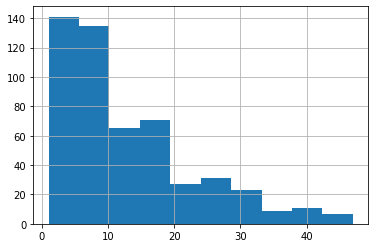

In [70]:
brand_data.n_functions.hist()

<AxesSubplot:>

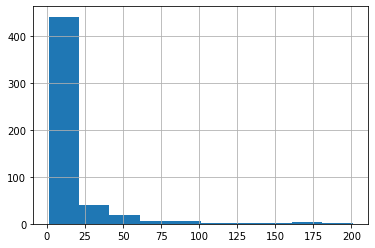

In [71]:
brand_data.n_modules.hist()

<AxesSubplot:>

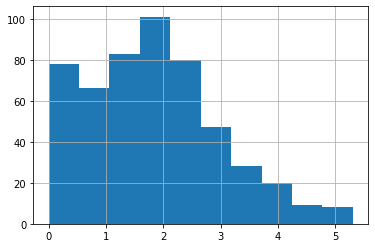

In [72]:
np.log(brand_data.n_modules).hist()

[Text(0.5, 1.0, 'Number of functions produced by brand vs. average product popularity of brand')]

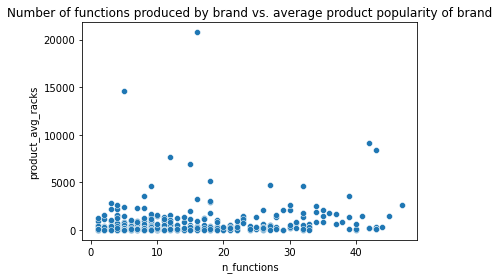

In [73]:
g = sns.scatterplot(data = brand_data, x='n_functions', y = 'product_avg_racks')
g.set(title = 'Number of functions produced by brand vs. average product popularity of brand')

[Text(0.5, 1.0, 'Number of functions produced by brand vs. max product popularity of brand')]

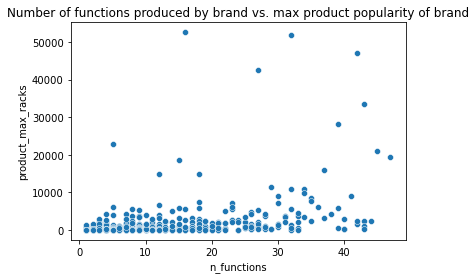

In [74]:
g = sns.scatterplot(data = brand_data, x='n_functions', y = 'product_max_racks')
g.set(title = 'Number of functions produced by brand vs. max product popularity of brand')

[Text(0.5, 1.0, 'Number of functions produced by brand vs. max product popularity of brand')]

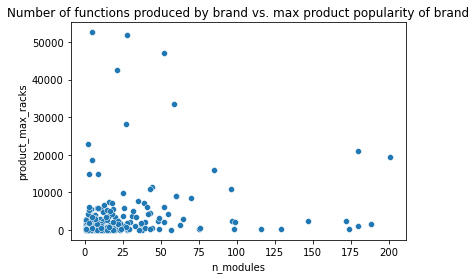

In [75]:
g = sns.scatterplot(data = brand_data, x='n_modules', y = 'product_max_racks')
g.set(title = 'Number of functions produced by brand vs. max product popularity of brand')

In [76]:
brand_data.drop('brand',axis=1).corr()

,n_functions,n_modules,product_avg_racks,product_max_racks,n_top_products,per_top_products
n_functions,1.000000,0.737548,0.177355,0.372657,0.390476,0.184071
n_modules,0.737548,1.000000,0.071281,0.252768,0.421362,0.088052
product_avg_racks,0.177355,0.071281,1.000000,0.814066,0.442307,0.831615
product_max_racks,0.372657,0.252768,0.814066,1.000000,0.649609,0.701711
n_top_products,0.390476,0.421362,0.442307,0.649609,1.000000,0.497434
per_top_products,0.184071,0.088052,0.831615,0.701711,0.497434,1.000000


## Are the most popular products from the most successful brands in distinct or overlapping categories?

Examine two metrics of successful:
- A large number of their products are in the top 5% most popular modules
- A large proportion of their products are in the top 5% most popular modules

For their products in the top 5%, we can ask:
- are they in distinct categories?
- are they in overlapping categories? to what extent?

In [77]:
brand_data.sort_values(by='per_top_products', ascending = False)

,brand,n_functions,n_modules,product_avg_racks,product_max_racks,n_top_products,per_top_products
390,Squarp Instruments,9,3,4641.666667,5420.0,3.0,1.00000
105,DivKid,5,2,14615.500000,22862.0,2.0,1.00000
401,Strymon,12,3,7678.333333,14824.0,3.0,1.00000
280,Mutable instruments,16,5,20765.400000,52604.0,4.0,0.80000
190,Intellijel,43,59,8397.305085,33473.0,47.0,0.79661
...,...,...,...,...,...,...,...
180,Hikari Instruments,19,9,304.666667,991.0,0.0,0.00000
178,Hexdevices,4,4,27.500000,53.0,0.0,0.00000
176,Hampshire Electronics,9,9,27.444444,67.0,0.0,0.00000
175,HackMe,2,2,213.000000,234.0,0.0,0.00000


We want to define a metric of amount of 'redundancy' of functionality in each company's products in the top 5%

(aside: we may want to do this for each of their individual relative top products or products which reach a certain level of popularity)

For a given collection of products, we want a metric which describes how much redundancy in functionality there is in the collection.

We first consider the assignment of any collection of products to a series indexed by functions, which gives the number of modules in the collection which have that function. For example, in the collection of modules in the top 5% made by a brand, if there are 3 modules which share the function 'lfo', then the coordinate indexed by 'lfo' will be 3 for that collection.

To get a single number representing the overall redundancy in the collection, we can take the product of all of these numbers, which captures how many times products overlap per function. If there is no redundancy in the collection, this number will be 1. If there are n products overlapping on m features, this number will be nm. This property is 'exponential' in that if we have two collections of products with disjoint functionality with redundancy values n and m, their 'sum' - the overall collection - will have redundancy number nm. 

Since we would like collections with no redundancy to have redundancy number 0, and we would like this to be additive with collections of products with disjoint features, we take the log.

In [78]:
#Function takes in a dataframe of products exploded by function, and computes the number described above
#Float conversion is to deal with large numbers before log is taken
def redundant_products(product_df):
    return np.log(np.product(product_df.groupby('functions')['module_name']\
                             .unique().apply(len).astype('float').values))

In [79]:
# test_brand = np.random.choice(df_brands.manufacturer_name.unique())
# test_prod = brands_exploded[brands_exploded.manufacturer_name == test_brand]
# len(test_prod)

In [80]:
# redundant_products(test_prod)

In [81]:
#We first add this redundancy information for overall catalog by each brand.
#This gives a sense of how redundant the products are in a brand's catalog per function.
brand_data = brand_data.merge(
brands_exploded.groupby('manufacturer_name').apply(redundant_products).reset_index().rename(columns={0:'prod_redundancy'}),
                 left_on = 'brand', right_on = 'manufacturer_name', how='left').drop('manufacturer_name',axis=1)

In [82]:
brand_data.prod_redundancy.mean()

7.897898433371802

In [83]:
brand_data.prod_redundancy.median()

2.772588722239781

In [84]:
# brand_data.merge(
#     top_products.explode('functions').groupby('manufacturer_name')\
#         .apply(redundant_products).reset_index().rename(columns={0:'top_prod_redundancy'}),
#      left_on = 'brand', right_on = 'manufacturer_name', how='left').drop('manufacturer_name',axis=1)

In [85]:
brands_top_prod = brand_data.merge(
    top_products.explode('functions').groupby('manufacturer_name')\
        .apply(redundant_products).reset_index().rename(columns={0:'top_prod_redundancy'}),
     left_on = 'brand', right_on = 'manufacturer_name', how='inner').drop('manufacturer_name',axis=1)

<AxesSubplot:xlabel='n_top_products', ylabel='top_prod_redundancy'>

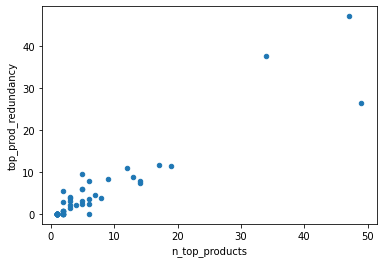

In [86]:
brands_top_prod.plot(x='n_top_products', y='top_prod_redundancy', kind = 'scatter')

There is strong correlation, but product redundancy is not normal. May want to look at Spearman's correlation.

In [87]:
def pairs_to_map(pairs):
    dic = {}
    for pair in pairs:
        key, value = pair
        dic[key] = value
    return lambda x: dic[x]

In [88]:
n_prod_ranker = pairs_to_map([*zip(brands_top_prod.n_top_products.sort_values().unique(),
      range(len(brands_top_prod.n_top_products.sort_values().unique())))])
brands_top_prod['top_prod_rank'] = brands_top_prod.n_top_products.apply(n_prod_ranker)

In [89]:
top_red_ranker = pairs_to_map([*zip(brands_top_prod.top_prod_redundancy.sort_values().unique(),
      range(len(brands_top_prod.top_prod_redundancy.sort_values().unique())))])
brands_top_prod['top_red_rank'] = brands_top_prod.top_prod_redundancy.apply(top_red_ranker)

In [90]:
prod_red_ranker = pairs_to_map([*zip(brands_top_prod.prod_redundancy.sort_values().unique(),
      range(len(brands_top_prod.prod_redundancy.sort_values().unique())))])
brands_top_prod['prod_red_rank'] = brands_top_prod.prod_redundancy.apply(prod_red_ranker)

In [91]:
brands_top_prod.iloc[:,-3:].corr(method = 'spearman')

,top_prod_rank,top_red_rank,prod_red_rank
top_prod_rank,1.000000,0.899520,0.544346
top_red_rank,0.899520,1.000000,0.551205
prod_red_rank,0.544346,0.551205,1.000000


Here we can see that the rank correlation of number of top products is much higher with redundancy in top products than overall products, for brands who produce a top product. This suggests that brands tend to have more succesful products in an overlapping domain rather than from a wider range of functions. Some confounds include simply having more products, but that is not as good a predictor of popularity.

It is to be expected that past a certain point of top products, redundancy would have to occur. However, this trend 

<AxesSubplot:xlabel='n_top_products', ylabel='prod_redundancy'>

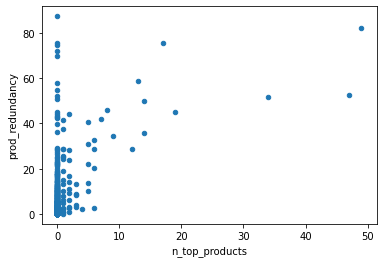

In [95]:
brand_data.plot(kind='scatter', x='n_top_products', y='prod_redundancy')

<AxesSubplot:xlabel='prod_redundancy', ylabel='per_top_products'>

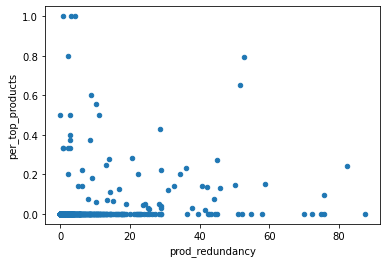

In [94]:
brand_data.plot(kind='scatter', x='prod_redundancy', y='per_top_products')

Among brands with top products, there is a strong correlation with redundancy between their top products and the number of top products more than any other factor. However, 

# Some takeaways:
 - some gaps where there are highly popular functions, but comparatively few being developed
 - price is not a strong correlate of popularity, suggesting that this is not a competative parameter
 - multifunction preferred to single function
 - a brands top products tend to cluster towards overlapping functions, rather than spread over distinct functions, suggesting an advantage to specialization
 
Further exploration:
- optimal size(s) are likely relativized to function(s)
- look for successful function pairings